This notebook source copied from https://www.tensorflow.org/tutorials/keras/regression

In [73]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [74]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [76]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.6.0


In [77]:
url = r'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = [r'MPG', r'Cylinders', r'Displacement', r'Horsepower', r'Weight',
                r'Acceleration', r'Model Year', r'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values=r'?', comment='\t',
                          sep=r' ', skipinitialspace=True)

In [78]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [79]:
# Count NaN.
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [80]:
# Remove NaN rows.
dataset = dataset.dropna()

In [81]:
# "Origin" columns not numeric, convert to one-hot data.
dataset[r'Origin'] = dataset[r'Origin'].map({1: r'USA', 2: r'Europe', 3: r'Japan'})

In [82]:
dataset = pd.get_dummies(dataset, columns=[r'Origin'], prefix=r'', prefix_sep=r'')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [83]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

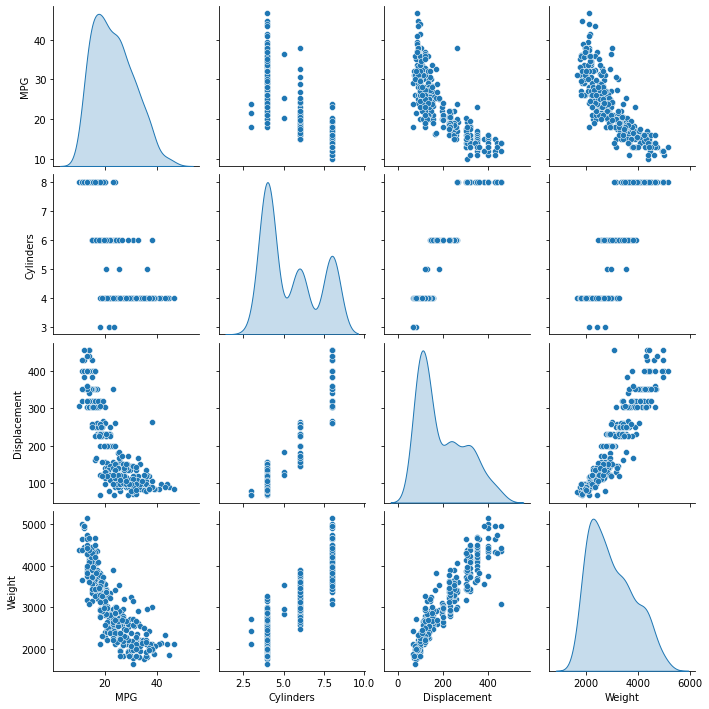

In [84]:
sns.pairplot(train_dataset[[r'MPG', r'Cylinders', r'Displacement', r'Weight']], diag_kind=r'kde')

In [85]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [86]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop(r'MPG')
test_labels = test_features.pop(r'MPG')

In [87]:
train_dataset.describe().transpose()[[r'mean', r'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [88]:
normalizer = preprocessing.Normalization(axis=-1)

In [89]:
# Adapt preprocessing layer for normalization.
normalizer.adapt(np.array(train_features))

In [90]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [91]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print(r'First example:', first)
    print()
    print(r'Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


### Linear regression

One Variable

Start with a single-variable linear regression, to predict MPG from Horsepower.

In [92]:
horsepower = np.array(train_features[r'Horsepower'])

# Normalize "Horsepower".
horsepower_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [93]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [94]:
# predict (no learning).
horsepower_model.predict(horsepower[:10])

array([[-0.438],
       [-0.247],
       [ 0.808],
       [-0.614],
       [-0.555],
       [-0.218],
       [-0.658],
       [-0.555],
       [-0.145],
       [-0.247]], dtype=float32)

In [95]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss=r'mean_absolute_error')

In [96]:
%%time
history = horsepower_model.fit(
    train_features[r'Horsepower'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split=0.2)

CPU times: user 2.37 s, sys: 381 ms, total: 2.75 s
Wall time: 2 s


In [97]:
hist = pd.DataFrame(history.history)
hist[r'epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.804730,4.153766,95
96,3.812209,4.132897,96
97,3.807573,4.178833,97
98,3.803386,4.195299,98
99,3.805251,4.203034,99


In [98]:
def plot_loss(history):
    plt.plot(history.history[r'loss'], label=r'loss')
    plt.plot(history.history[r'val_loss'], label=r'val_loss')
    plt.ylim([0, 10])
    plt.xlabel(r'Epoch')
    plt.ylabel(r'Error [MPG]')
    plt.legend()
    plt.grid(True)

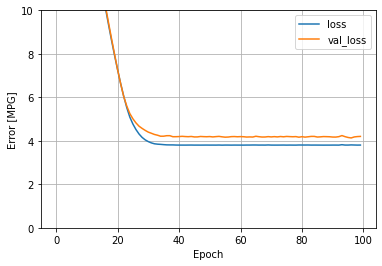

In [99]:
plot_loss(history)

In [100]:
test_results = {}

test_results[r'horsepower_model'] = horsepower_model.evaluate(
    test_features[r'Horsepower'],
    test_labels, verbose=0)

In [101]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [102]:
def plot_horsepower(x, y):
    plt.scatter(train_features[r'Horsepower'], train_labels, label=r'Data')
    plt.plot(x, y, color=r'k', label=r'Predictions')
    plt.xlabel(r'Horsepower')
    plt.ylabel(r'MPG')
    plt.legend()

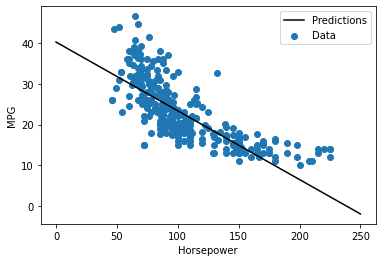

In [103]:
plot_horsepower(x, y)

### Multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

This time use the `Normalization` layer that was adapted to the whole dataset.

In [107]:
# This model use all dataset columns.
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [108]:
linear_model.predict(train_features[:10])

array([[-0.51 ],
       [ 0.067],
       [ 1.046],
       [-0.465],
       [-0.263],
       [-0.412],
       [-0.609],
       [-0.722],
       [-0.47 ],
       [-0.227]], dtype=float32)

In [109]:
# `shape` is `(9, 1)` (two-dimensional array `[9][1]`).
linear_model.layers[1].kernel

<tf.Variable 'dense_3/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.692],
       [ 0.047],
       [ 0.408],
       [ 0.748],
       [-0.383],
       [ 0.089],
       [ 0.341],
       [ 0.728],
       [ 0.572]], dtype=float32)>

In [110]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss=r'mean_absolute_error')

In [111]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 2.71 s, sys: 397 ms, total: 3.11 s
Wall time: 2.31 s


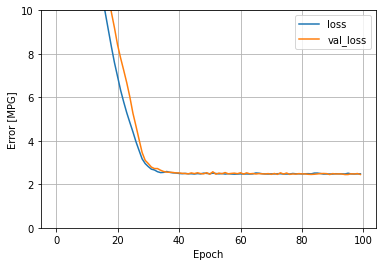

In [112]:
plot_loss(history)

In [113]:
test_results[r'linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

### A DNN regression

The previous section implemented linear models for single and multiple inputs.

This section implements single-input and multiple-input DNN models. The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer.
* Two hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear single-output layer.

Both will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [114]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation=r'relu'),
        layers.Dense(64, activation=r'relu'),
        layers.Dense(1)
    ])

    model.compile(loss=r'mean_absolute_error',
                    optimizer=tf.keras.optimizers.Adam(0.001))
    return model

### One variable

Start with a DNN model for a single input: "Horsepower"

In [115]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [116]:
dnn_horsepower_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [117]:
%%time
history = dnn_horsepower_model.fit(
    train_features[r'Horsepower'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.16 s, sys: 495 ms, total: 3.66 s
Wall time: 2.74 s


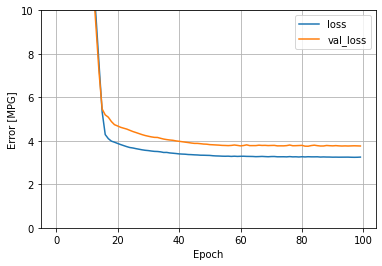

In [118]:
plot_loss(history)

In [119]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

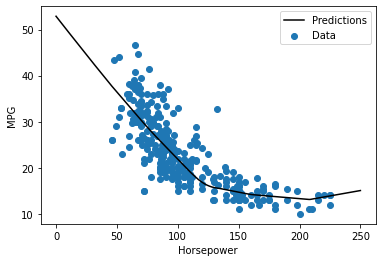

In [120]:
plot_horsepower(x, y)

In [121]:
test_results[r'dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features[r'Horsepower'], test_labels,
    verbose=0)

### Full model

If you repeat this process using all the inputs it slightly improves the performance on the validation dataset.

In [122]:
dnn_model = build_and_compile_model(normalizer)

In [123]:
dnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 9)                 19        
_________________________________________________________________
dense_7 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [124]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.12 s, sys: 476 ms, total: 3.59 s
Wall time: 2.58 s


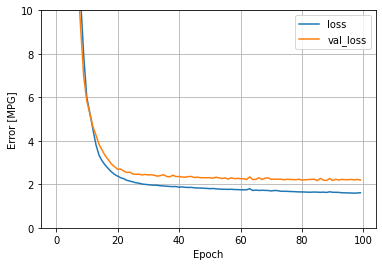

In [125]:
plot_loss(history)

In [126]:
test_results[r'dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [127]:
pd.DataFrame(test_results, index=[r'Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.648187
linear_model,2.469097
dnn_horsepower_model,2.909935
dnn_model,1.785763


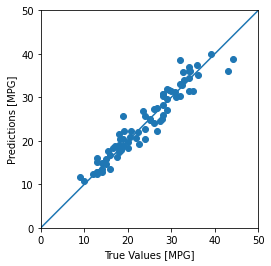

In [128]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect=r'equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel(r'True Values [MPG]')
plt.ylabel(r'Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

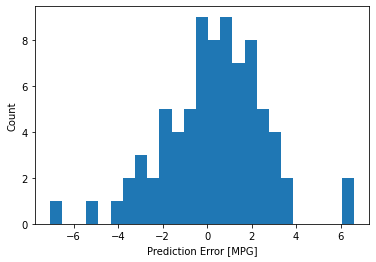

In [129]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel(r'Prediction Error [MPG]')
_ = plt.ylabel(r'Count')

In [130]:
# If you're happy with the model save it for later use:
dnn_model.save(r'dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


In [131]:
reloaded = tf.keras.models.load_model(r'dnn_model')

test_results[r'reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [132]:
pd.DataFrame(test_results, index=[r'Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.648187
linear_model,2.469097
dnn_horsepower_model,2.909935
dnn_model,1.785763
reloaded,1.785763
